<FONT size="6pt" color='Blue'> <center>Development of a Text Summarization Systeme</center></FONT>

### This notebook is dedicated to building a Text Summarization System.

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Télécharger les ressources NLTK nécessaires
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("Bibliothèques chargées avec succès!")

Bibliothèques chargées avec succès!


- **Loading and preparing the data.**

In [3]:
df_reviews = pd.read_csv('df_reviews.csv')
df_reviews.head()

,sentiment,text,tokens,length,processed_text
0,neutral,decide eat aware going take 2 hour beginning e...,"['decide', 'eat', 'aware', 'going', 'take', '2...",277,decide eat aware going take 2 hour beginning e...
1,positive,ive taken lot spin class year nothing compare ...,"['ive', 'taken', 'lot', 'spin', 'class', 'year...",540,ive taken lot spin class year nothing compare ...
2,neutral,family diner buffet eclectic assortment large ...,"['family', 'diner', 'buffet', 'eclectic', 'ass...",260,family diner buffet eclectic assortment large ...
3,positive,wow yummy different delicious favorite lamb cu...,"['wow', 'yummy', 'different', 'delicious', 'fa...",153,wow yummy different delicious favorite lamb cu...
4,positive,cute interior owner gave u tour upcoming patio...,"['cute', 'interior', 'owner', 'gave', 'u', 'to...",380,cute interior owner gave u tour upcoming patio...


In [4]:
# Analyser la longueur des textes
df_reviews['text_length'] = df_reviews['text'].str.len()
df_reviews['word_count'] = df_reviews['text'].str.split().str.len()

print("=== STATISTIQUES DES TEXTES ===")
print(f"Nombre total d'avis: {len(df_reviews)}")
print(f"Longueur moyenne des textes: {df_reviews['text_length'].mean():.1f} caractères")
print(f"Nombre moyen de mots: {df_reviews['word_count'].mean():.1f} mots")
print(f"Texte le plus long: {df_reviews['text_length'].max()} caractères")

# Sélectionner les avis assez longs pour la summarisation (>100 mots)
long_reviews = df_reviews[df_reviews['word_count'] > 100].copy()
print(f"\nAvis longs (>100 mots): {len(long_reviews)}")

if len(long_reviews) == 0:
    # Si pas d'avis longs, utiliser tous les avis
    long_reviews = df_reviews.copy()
    print("Utilisation de tous les avis pour la démonstration")

print(f"\nExemple d'avis long:")
sample_text = long_reviews.iloc[0]['text']
print(f"Longueur: {len(sample_text)} caractères")
print(f"Texte: {sample_text[:300]}...")

=== STATISTIQUES DES TEXTES ===
Nombre total d'avis: 50000
Longueur moyenne des textes: 338.5 caractères
Nombre moyen de mots: 52.1 mots
Texte le plus long: 3328 caractères

Avis longs (>100 mots): 5758

Exemple d'avis long:
Longueur: 884 caractères
Texte: really 3 4 star one love 96th street naked tchopstix excited see one closer house vibe totally different geared take although decent size dining area order counter deliver daughter tried sushi bowl pick piece paper select choice protein vegetable rice topping like fact paper dont guess thing shout c...


- **Preprocessing for summarization.**

In [5]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
    
    def clean_text(self, text):
        """Nettoyer le texte"""
        # Supprimer les caractères spéciaux et normaliser
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    def tokenize_sentences(self, text):
        """Diviser le texte en phrases"""
        sentences = sent_tokenize(text)
        # Filtrer les phrases trop courtes
        sentences = [s for s in sentences if len(s.split()) > 3]
        return sentences
    
    def preprocess_sentence(self, sentence):
        """Prétraiter une phrase pour l'analyse"""
        # Nettoyer et tokeniser
        clean_sentence = self.clean_text(sentence.lower())
        words = word_tokenize(clean_sentence)
        
        # Supprimer les stopwords et stemmer
        words = [self.stemmer.stem(word) for word in words 
                if word not in self.stop_words and len(word) > 2]
        
        return ' '.join(words)

preprocessor = TextPreprocessor()

# Test sur un exemple
sample_sentences = preprocessor.tokenize_sentences(sample_text)
print(f"Nombre de phrases dans l'exemple: {len(sample_sentences)}")
print("\nPremières phrases:")
for i, sentence in enumerate(sample_sentences[:3]):
    print(f"{i+1}. {sentence}")

Nombre de phrases dans l'exemple: 1

Premières phrases:
1. really 3 4 star one love 96th street naked tchopstix excited see one closer house vibe totally different geared take although decent size dining area order counter deliver daughter tried sushi bowl pick piece paper select choice protein vegetable rice topping like fact paper dont guess thing shout counter tell server want sushi bowl good wonderful choice particularly vegetable seemed little limiting felt rice food item sauce tasty husband ordered maui roll favorite roll 96th street location standard good quality consistently good 96th street would go back though think lot people would happy sushi bowl want make comment low review people given place service people sushi place isnt mcdonalds bit slower going order get five minute even though called express healthy alternative fast food area worth wait oh try bubble tea strawberry quite yummy next time going try vanilla chai


- **Method 1 - TF-IDF-based summarization.**

In [6]:
class TFIDFSummarizer:
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
        self.vectorizer = TfidfVectorizer(max_features=1000)
    
    def summarize(self, text, num_sentences=3):
        """
        Générer un résumé extractif basé sur TF-IDF
        """
        sentences = self.preprocessor.tokenize_sentences(text)
        
        if len(sentences) <= num_sentences:
            return sentences
        
        # Prétraiter les phrases
        processed_sentences = [self.preprocessor.preprocess_sentence(s) for s in sentences]
        
        # Calculer les scores TF-IDF
        try:
            tfidf_matrix = self.vectorizer.fit_transform(processed_sentences)
            sentence_scores = np.sum(tfidf_matrix.toarray(), axis=1)
            
            # Sélectionner les meilleures phrases
            top_indices = sentence_scores.argsort()[-num_sentences:][::-1]
            top_indices.sort()  # Maintenir l'ordre original
            
            summary_sentences = [sentences[i] for i in top_indices]
            return summary_sentences
        
        except:
            # En cas d'erreur, retourner les premières phrases
            return sentences[:num_sentences]

# Test de la méthode TF-IDF
tfidf_summarizer = TFIDFSummarizer(preprocessor)
tfidf_summary = tfidf_summarizer.summarize(sample_text, num_sentences=3)

print("=== RÉSUMÉ TF-IDF ===")
print(f"Texte original: {len(sample_text)} caractères")
print(f"Résumé: {len(' '.join(tfidf_summary))} caractères")
print("\nRésumé:")
for i, sentence in enumerate(tfidf_summary, 1):
    print(f"{i}. {sentence}")

=== RÉSUMÉ TF-IDF ===
Texte original: 884 caractères
Résumé: 884 caractères

Résumé:
1. really 3 4 star one love 96th street naked tchopstix excited see one closer house vibe totally different geared take although decent size dining area order counter deliver daughter tried sushi bowl pick piece paper select choice protein vegetable rice topping like fact paper dont guess thing shout counter tell server want sushi bowl good wonderful choice particularly vegetable seemed little limiting felt rice food item sauce tasty husband ordered maui roll favorite roll 96th street location standard good quality consistently good 96th street would go back though think lot people would happy sushi bowl want make comment low review people given place service people sushi place isnt mcdonalds bit slower going order get five minute even though called express healthy alternative fast food area worth wait oh try bubble tea strawberry quite yummy next time going try vanilla chai


- **Method 2 - TextRank-based summarization**

In [7]:
class TextRankSummarizer:
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
    
    def calculate_similarity(self, sent1, sent2):
        """Calculer la similarité entre deux phrases"""
        words1 = set(sent1.split())
        words2 = set(sent2.split())
        
        if len(words1) == 0 or len(words2) == 0:
            return 0
        
        # Similarité Jaccard
        intersection = words1.intersection(words2)
        union = words1.union(words2)
        
        return len(intersection) / len(union)
    
    def build_similarity_matrix(self, sentences):
        """Construire la matrice de similarité"""
        processed_sentences = [self.preprocessor.preprocess_sentence(s) for s in sentences]
        n = len(sentences)
        similarity_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    similarity_matrix[i][j] = self.calculate_similarity(
                        processed_sentences[i], processed_sentences[j]
                    )
        
        return similarity_matrix
    
    def summarize(self, text, num_sentences=3):
        """
        Générer un résumé extractif basé sur TextRank
        """
        sentences = self.preprocessor.tokenize_sentences(text)
        
        if len(sentences) <= num_sentences:
            return sentences
        
        # Construire la matrice de similarité
        similarity_matrix = self.build_similarity_matrix(sentences)
        
        # Créer le graphe et appliquer PageRank
        graph = nx.from_numpy_array(similarity_matrix)
        scores = nx.pagerank(graph)
        
        # Sélectionner les meilleures phrases
        ranked_sentences = sorted(((scores[i], i) for i in range(len(sentences))), 
                                reverse=True)
        
        top_indices = [idx for _, idx in ranked_sentences[:num_sentences]]
        top_indices.sort()  # Maintenir l'ordre original
        
        summary_sentences = [sentences[i] for i in top_indices]
        return summary_sentences

# Test de la méthode TextRank
textrank_summarizer = TextRankSummarizer(preprocessor)
textrank_summary = textrank_summarizer.summarize(sample_text, num_sentences=3)

print("=== RÉSUMÉ TEXTRANK ===")
print(f"Résumé: {len(' '.join(textrank_summary))} caractères")
print("\nRésumé:")
for i, sentence in enumerate(textrank_summary, 1):
    print(f"{i}. {sentence}")

=== RÉSUMÉ TEXTRANK ===
Résumé: 884 caractères

Résumé:
1. really 3 4 star one love 96th street naked tchopstix excited see one closer house vibe totally different geared take although decent size dining area order counter deliver daughter tried sushi bowl pick piece paper select choice protein vegetable rice topping like fact paper dont guess thing shout counter tell server want sushi bowl good wonderful choice particularly vegetable seemed little limiting felt rice food item sauce tasty husband ordered maui roll favorite roll 96th street location standard good quality consistently good 96th street would go back though think lot people would happy sushi bowl want make comment low review people given place service people sushi place isnt mcdonalds bit slower going order get five minute even though called express healthy alternative fast food area worth wait oh try bubble tea strawberry quite yummy next time going try vanilla chai


- **Method 3 - Word frequency-based summarization.**

In [8]:
class FrequencySummarizer:
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
    
    def calculate_word_frequencies(self, text):
        """Calculer les fréquences des mots"""
        clean_text = self.preprocessor.clean_text(text.lower())
        words = word_tokenize(clean_text)
        
        # Filtrer les stopwords
        words = [word for word in words if word not in self.preprocessor.stop_words 
                and len(word) > 2]
        
        word_freq = Counter(words)
        
        # Normaliser les fréquences
        max_freq = max(word_freq.values()) if word_freq else 1
        for word in word_freq:
            word_freq[word] = word_freq[word] / max_freq
        
        return word_freq
    
    def score_sentences(self, sentences, word_freq):
        """Scorer les phrases basé sur les fréquences des mots"""
        sentence_scores = {}
        
        for sentence in sentences:
            words = word_tokenize(self.preprocessor.clean_text(sentence.lower()))
            words = [word for word in words if word not in self.preprocessor.stop_words]
            
            score = 0
            word_count = 0
            
            for word in words:
                if word in word_freq:
                    score += word_freq[word]
                    word_count += 1
            
            if word_count > 0:
                sentence_scores[sentence] = score / word_count
            else:
                sentence_scores[sentence] = 0
        
        return sentence_scores
    
    def summarize(self, text, num_sentences=3):
        """
        Générer un résumé extractif basé sur la fréquence des mots
        """
        sentences = self.preprocessor.tokenize_sentences(text)
        
        if len(sentences) <= num_sentences:
            return sentences
        
        # Calculer les fréquences et scorer les phrases
        word_freq = self.calculate_word_frequencies(text)
        sentence_scores = self.score_sentences(sentences, word_freq)
        
        # Sélectionner les meilleures phrases
        ranked_sentences = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)
        
        summary_sentences = []
        for sentence, score in ranked_sentences[:num_sentences]:
            summary_sentences.append(sentence)
        
        # Maintenir l'ordre original
        summary_sentences = [s for s in sentences if s in summary_sentences]
        
        return summary_sentences

# Test de la méthode par fréquence
frequency_summarizer = FrequencySummarizer(preprocessor)
frequency_summary = frequency_summarizer.summarize(sample_text, num_sentences=3)

print("=== RÉSUMÉ PAR FRÉQUENCE ===")
print(f"Résumé: {len(' '.join(frequency_summary))} caractères")
print("\nRésumé:")
for i, sentence in enumerate(frequency_summary, 1):
    print(f"{i}. {sentence}")

=== RÉSUMÉ PAR FRÉQUENCE ===
Résumé: 884 caractères

Résumé:
1. really 3 4 star one love 96th street naked tchopstix excited see one closer house vibe totally different geared take although decent size dining area order counter deliver daughter tried sushi bowl pick piece paper select choice protein vegetable rice topping like fact paper dont guess thing shout counter tell server want sushi bowl good wonderful choice particularly vegetable seemed little limiting felt rice food item sauce tasty husband ordered maui roll favorite roll 96th street location standard good quality consistently good 96th street would go back though think lot people would happy sushi bowl want make comment low review people given place service people sushi place isnt mcdonalds bit slower going order get five minute even though called express healthy alternative fast food area worth wait oh try bubble tea strawberry quite yummy next time going try vanilla chai


- **Comparison of summarization methods.**

In [9]:
def compare_summarization_methods(text, num_sentences=3):
    """
    Comparer les différentes méthodes de summarisation
    """
    print("=== COMPARAISON DES MÉTHODES ===")
    print(f"Texte original ({len(text)} caractères):")
    print(f"{text[:200]}...")
    print("\n" + "="*50)
    
    # Méthode 1: TF-IDF
    tfidf_summary = tfidf_summarizer.summarize(text, num_sentences)
    print(f"\n1. RÉSUMÉ TF-IDF ({len(' '.join(tfidf_summary))} caractères):")
    for sentence in tfidf_summary:
        print(f"   • {sentence}")
    
    # Méthode 2: TextRank
    textrank_summary = textrank_summarizer.summarize(text, num_sentences)
    print(f"\n2. RÉSUMÉ TEXTRANK ({len(' '.join(textrank_summary))} caractères):")
    for sentence in textrank_summary:
        print(f"   • {sentence}")
    
    # Méthode 3: Fréquence
    frequency_summary = frequency_summarizer.summarize(text, num_sentences)
    print(f"\n3. RÉSUMÉ FRÉQUENCE ({len(' '.join(frequency_summary))} caractères):")
    for sentence in frequency_summary:
        print(f"   • {sentence}")
    
    return {
        'tfidf': tfidf_summary,
        'textrank': textrank_summary,
        'frequency': frequency_summary
    }

# Comparer les méthodes sur l'exemple
comparison_results = compare_summarization_methods(sample_text, 3)

=== COMPARAISON DES MÉTHODES ===
Texte original (884 caractères):
really 3 4 star one love 96th street naked tchopstix excited see one closer house vibe totally different geared take although decent size dining area order counter deliver daughter tried sushi bowl pi...


1. RÉSUMÉ TF-IDF (884 caractères):
   • really 3 4 star one love 96th street naked tchopstix excited see one closer house vibe totally different geared take although decent size dining area order counter deliver daughter tried sushi bowl pick piece paper select choice protein vegetable rice topping like fact paper dont guess thing shout counter tell server want sushi bowl good wonderful choice particularly vegetable seemed little limiting felt rice food item sauce tasty husband ordered maui roll favorite roll 96th street location standard good quality consistently good 96th street would go back though think lot people would happy sushi bowl want make comment low review people given place service people sushi place isnt

- **Application on multiple reviews.**

In [10]:
# Appliquer la summarisation sur plusieurs avis
def summarize_multiple_reviews(df, num_reviews=5, num_sentences=2):
    """
    Résumer plusieurs avis et comparer les méthodes
    """
    results = []
    
    # Sélectionner des avis de différentes longueurs
    sample_reviews = df.nlargest(num_reviews, 'word_count')
    
    for idx, row in sample_reviews.iterrows():
        text = row['text']
        sentiment = row['sentiment']
        
        print(f"\n{'='*60}")
        print(f"AVIS #{idx} - Sentiment: {sentiment}")
        print(f"Longueur: {len(text)} caractères, {row['word_count']} mots")
        print(f"Texte original: {text[:150]}...")
        
        # Générer les résumés
        summaries = {
            'review_id': idx,
            'original_text': text,
            'sentiment': sentiment,
            'word_count': row['word_count'],
            'tfidf_summary': ' '.join(tfidf_summarizer.summarize(text, num_sentences)),
            'textrank_summary': ' '.join(textrank_summarizer.summarize(text, num_sentences)),
            'frequency_summary': ' '.join(frequency_summarizer.summarize(text, num_sentences))
        }
        
        print(f"\nRÉSUMÉS:")
        print(f"TF-IDF: {summaries['tfidf_summary']}")
        print(f"TextRank: {summaries['textrank_summary']}")
        print(f"Fréquence: {summaries['frequency_summary']}")
        
        results.append(summaries)
    
    return pd.DataFrame(results)

# Appliquer sur plusieurs avis
summary_results = summarize_multiple_reviews(long_reviews, num_reviews=3, num_sentences=2)


AVIS #48405 - Sentiment: negative
Longueur: 3144 caractères, 496 mots
Texte original: place missed mark badly tonight decided head ralphs park celebrating father bday first walked greeted werent sure place exactly worked u walk large op...

RÉSUMÉS:
TF-IDF: place missed mark badly tonight decided head ralphs park celebrating father bday first walked greeted werent sure place exactly worked u walk large open room right dining room immediately left sits desk like hostess station maybe hostess front desk would made sense however endedup moving past station veering left bar maybe purpose honestly ended looking like go moved back dining room wait could tell need help took name found reservation seated u approx 5306pm second sat took awhile waiter greet u another big table 6 7 next u already first part meal waiter visited table prior greeting table wasnt big deal given menu provided drink waiter ran special well decided order whole meal right third good apps ordered 1smoked oyster definite 

- **Evaluation of summary quality.**

=== ÉVALUATION DES MÉTHODES ===

Moyennes par méthode:
           compression_ratio  rouge_1_score  summary_length
method                                                     
frequency                1.0            1.0        3228.667
textrank                 1.0            1.0        3228.667
tfidf                    1.0            1.0        3228.667


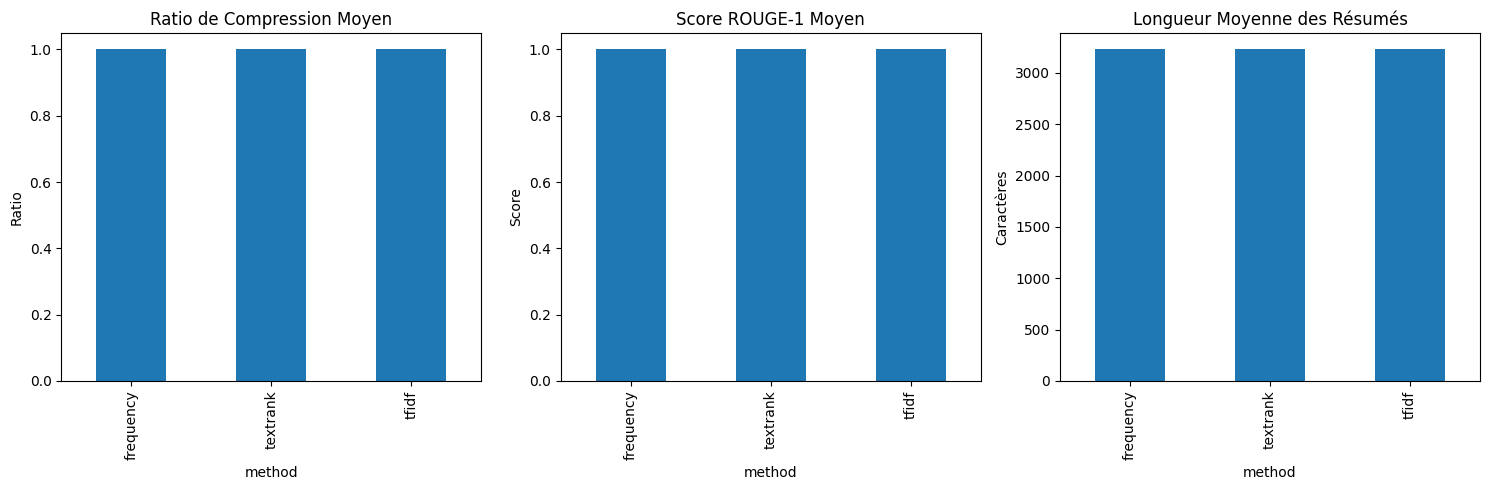

In [11]:
class SummaryEvaluator:
    def __init__(self):
        self.preprocessor = TextPreprocessor()
    
    def calculate_rouge_1(self, summary, reference):
        """
        Calculer ROUGE-1 (approximation simple)
        """
        summary_words = set(word_tokenize(summary.lower()))
        reference_words = set(word_tokenize(reference.lower()))
        
        if len(reference_words) == 0:
            return 0
        
        overlap = summary_words.intersection(reference_words)
        precision = len(overlap) / len(summary_words) if len(summary_words) > 0 else 0
        recall = len(overlap) / len(reference_words)
        
        if precision + recall == 0:
            return 0
        
        f1 = 2 * (precision * recall) / (precision + recall)
        return f1
    
    def calculate_compression_ratio(self, original_text, summary):
        """
        Calculer le ratio de compression
        """
        return len(summary) / len(original_text)
    
    def evaluate_summaries(self, df_summaries):
        """
        Évaluer la qualité des résumés
        """
        evaluation_results = []
        
        for _, row in df_summaries.iterrows():
            original = row['original_text']
            
            # Évaluer chaque méthode
            for method in ['tfidf', 'textrank', 'frequency']:
                summary = row[f'{method}_summary']
                
                # Métriques d'évaluation
                compression_ratio = self.calculate_compression_ratio(original, summary)
                
                # Pour l'évaluation, nous utiliserons le texte original comme référence
                # (dans un vrai cas, vous auriez des résumés humains)
                rouge_score = self.calculate_rouge_1(summary, original)
                
                evaluation_results.append({
                    'review_id': row['review_id'],
                    'method': method,
                    'compression_ratio': compression_ratio,
                    'rouge_1_score': rouge_score,
                    'summary_length': len(summary),
                    'sentiment': row['sentiment']
                })
        
        return pd.DataFrame(evaluation_results)

# Évaluer les résumés
evaluator = SummaryEvaluator()
evaluation_df = evaluator.evaluate_summaries(summary_results)

print("=== ÉVALUATION DES MÉTHODES ===")
print("\nMoyennes par méthode:")
avg_by_method = evaluation_df.groupby('method').agg({
    'compression_ratio': 'mean',
    'rouge_1_score': 'mean',
    'summary_length': 'mean'
}).round(3)

print(avg_by_method)

# Graphiques d'évaluation
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ratio de compression
evaluation_df.groupby('method')['compression_ratio'].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title('Ratio de Compression Moyen')
axes[0].set_ylabel('Ratio')

# Score ROUGE-1
evaluation_df.groupby('method')['rouge_1_score'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Score ROUGE-1 Moyen')
axes[1].set_ylabel('Score')

# Longueur des résumés
evaluation_df.groupby('method')['summary_length'].mean().plot(kind='bar', ax=axes[2])
axes[2].set_title('Longueur Moyenne des Résumés')
axes[2].set_ylabel('Caractères')

plt.tight_layout()
plt.show()

- **Sauvegarde et fonction de summarisation**

In [14]:
# Sauvegarder les résultats
summary_results.to_csv('text_summaries.csv', index=False)
evaluation_df.to_csv('summary_evaluation.csv', index=False)

print("Fichiers sauvegardés:")
print("- text_summaries.csv: Résumés générés")
print("- summary_evaluation.csv: Évaluation des méthodes")

# Fonction finale pour résumer un nouveau texte
def summarize_text(text, method='textrank', num_sentences=3):
    """
    Fonction principale pour résumer un texte
    
    Args:
        text (str): Texte à résumer
        method (str): Méthode à utiliser ('tfidf', 'textrank', 'frequency')
        num_sentences (int): Nombre de phrases dans le résumé
    
    Returns:
        dict: Résultat avec résumé et métadonnées
    """
    
    if method == 'tfidf':
        summarizer = tfidf_summarizer
    elif method == 'textrank':
        summarizer = textrank_summarizer
    elif method == 'frequency':
        summarizer = frequency_summarizer
    else:
        raise ValueError("Méthode non supportée. Utilisez: 'tfidf', 'textrank', ou 'frequency'")
    
    # Générer le résumé
    summary_sentences = summarizer.summarize(text, num_sentences)
    summary_text = ' '.join(summary_sentences)
    
    # Calculer les métriques
    compression_ratio = len(summary_text) / len(text)
    
    result = {
        'original_text': text,
        'summary': summary_text,
        'method': method,
        'num_sentences': len(summary_sentences),
        'compression_ratio': compression_ratio,
        'original_length': len(text),
        'summary_length': len(summary_text)
    }
    
    return result

# Test de la fonction finale
test_text = long_reviews.iloc[0]['text']
final_result = summarize_text(test_text, method='textrank', num_sentences=2)

print("=== FONCTION DE RÉSUMÉ FINALE ===")
print(f"Méthode: {final_result['method']}")
print(f"Compression: {final_result['compression_ratio']:.2%}")
print(f"Texte original: {final_result['original_length']} caractères")
print(f"Résumé: {final_result['summary_length']} caractères")
print(f"\nRésumé généré:")
print(final_result['summary'])

# Code pour utilisation future (Streamlit, etc.)
print(f"\n=== CODE POUR STREAMLIT ===")

import pickle

# Sauvegarder les modèles
models = {
    'tfidf_summarizer': tfidf_summarizer,
    'textrank_summarizer': textrank_summarizer,
    'frequency_summarizer': frequency_summarizer,
    'preprocessor': preprocessor
}

with open('summarization_models.pkl', 'wb') as f:
    pickle.dump(models, f)


Fichiers sauvegardés:
- text_summaries.csv: Résumés générés
- summary_evaluation.csv: Évaluation des méthodes
=== FONCTION DE RÉSUMÉ FINALE ===
Méthode: textrank
Compression: 100.00%
Texte original: 884 caractères
Résumé: 884 caractères

Résumé généré:
really 3 4 star one love 96th street naked tchopstix excited see one closer house vibe totally different geared take although decent size dining area order counter deliver daughter tried sushi bowl pick piece paper select choice protein vegetable rice topping like fact paper dont guess thing shout counter tell server want sushi bowl good wonderful choice particularly vegetable seemed little limiting felt rice food item sauce tasty husband ordered maui roll favorite roll 96th street location standard good quality consistently good 96th street would go back though think lot people would happy sushi bowl want make comment low review people given place service people sushi place isnt mcdonalds bit slower going order get five minute even thou